# WaterShed Challenge

## 1. Libraries and Data

In [1]:
!pip install folium
!pip install pandas --upgrade

Requirement already up-to-date: pandas in c:\python39\lib\site-packages (1.4.3)


In [2]:
import pandas as pd
import datetime as dt
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df_flux = pd.read_csv('flux.csv')

## 2. EDA

In [4]:
df_flux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   basin_id    int64  
 2   flux        float64
 3   precip      float64
 4   temp_max    float64
 5   gauge_name  object 
 6   lat         float64
 7   lon         float64
 8   mean_elev   float64
 9   area_km2    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 318.9+ MB


In [5]:
df_flux['date'] = pd.to_datetime(df_flux['date'])
df_flux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   basin_id    int64         
 2   flux        float64       
 3   precip      float64       
 4   temp_max    float64       
 5   gauge_name  object        
 6   lat         float64       
 7   lon         float64       
 8   mean_elev   float64       
 9   area_km2    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 318.9+ MB


In [6]:
df_flux.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [7]:
df_flux['gauge_name'].value_counts()

Rio Aconcagua En Chacabuquito                   14670
Rio Cruces En Rucaco                            14649
Rio Choapa En Cuncumen                          14639
Rio Elqui En Algarrobal                         14634
Rio Cautin En Cajon                             14603
                                                ...  
Estero Chimbarongo En Santa Cruz                  328
Rio Chillan En Longitudinal                       302
Rio Pama Entrada Embalse Cogoti                   195
Estero Las Vegas Aguas Abajo Canal Las Vegas      195
Rio Blanco En Chaiten                             175
Name: gauge_name, Length: 503, dtype: int64

In [8]:
df_flux['basin_id'].value_counts()

5410002     14670
10134001    14649
4703002     14639
4320001     14634
9129002     14603
            ...  
6034001       328
8117001       302
4534001       195
5423002       195
10683002      175
Name: basin_id, Length: 503, dtype: int64

### 2.1 Locate stations on map

In [9]:
station_location = df_flux[['lat', 'lon']]
station_location.drop_duplicates(inplace=True)

C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_13508/570081029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_location.drop_duplicates(inplace=True)


In [10]:
# Locations lists
station_location_list = station_location.values.tolist()
station_location_cg = df_flux[['lat', 'lon']].mean().tolist()
# Start map
map1 = folium.Map(location=station_location_cg, 
                  tiles='CartoDB positron', 
                  zoom_start=4)
marker_cluster = folium.plugins.MarkerCluster().add_to(map1)
# Locate points
for point in range(0, len(station_location_list)):
    folium.Marker(station_location_list[point], 
                  popup='Name: '+df_flux['gauge_name'][point],
                  icon=folium.Icon(icon_color='white', 
                                   icon='male', 
                                   angle=0, 
                                   prefix='fa')).add_to(marker_cluster)
map1

We observe that we could group stations based on latitude.

### 2.2 Check for missing data

In [11]:
df_flux[df_flux.isnull().any(axis=1)]

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
60493,2020-05-06,1021001,1.707,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60494,2020-05-07,1021001,1.687,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60495,2020-05-08,1021001,1.698,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60496,2020-05-09,1021001,1.694,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60497,2020-05-10,1021001,1.690,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
...,...,...,...,...,...,...,...,...,...,...
4180475,2020-06-02,12930001,0.375,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180476,2020-06-03,12930001,0.342,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180477,2020-06-04,12930001,0.325,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180478,2020-06-05,12930001,0.311,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617


We have 4.1 million rows and about 0.1% have missing values. Let's check proportion of null values that each of the stations that appeared in last print have.

In [12]:
df_flux[df_flux.isnull().any(axis=1)]['gauge_name'].value_counts()

Rio Maipo En Cabimbao                               37
Estero Yerba Loca Antes Junta San Francisco         37
Rio Itata En Paso Hondo                             37
Rio Biobio En Desembocadura                         34
Rio Lauca En Japu (O En El Limite)                  32
                                                    ..
Rio Huequecura Aguas Arriba De Embalse Angostura    22
Rio Maule En Longitudinal                           15
Rio Tolten En Coipue                                15
Rio Chamiza Ante Junta Rio Chico                    10
Rio Loa Antes Represa Lequena                        2
Name: gauge_name, Length: 174, dtype: int64

In [13]:
stations_check = df_flux[df_flux.isnull().any(axis=1)]['gauge_name'].unique()  # Stations that have null values 
df_flux['has_nan'] = df_flux.isnull().any(axis=1)
df_check_nans = df_flux.groupby(['gauge_name','has_nan']).agg(counts = ('date','count'))
df_check_nans.reset_index(inplace=True)
df_check_nans = df_check_nans[df_check_nans['gauge_name'].isin(stations_check)]
df_check_nans = df_check_nans.pivot(index='gauge_name',columns='has_nan', values='counts').reset_index()
df_check_nans

has_nan,gauge_name,False,True
0,Estero Arrayan En La Montosa,13724,32
1,Estero Bellavista En Tom,3729,32
2,Estero Catemu En Puente Santa Rosa,11573,32
3,Estero Chimbarongo Bajo Embalse Convento Viejo,3957,32
4,Estero Chimbarongo En Puente El Huape,2906,32
...,...,...,...
169,Rio Trancura En Curarrehue,13913,32
170,Rio Tres Brazos Antes Bt. Sendos,12537,32
171,Rio Turbio En Varillar,14128,32
172,Rio Uble En San Fabian N 2,7407,32


<AxesSubplot:>

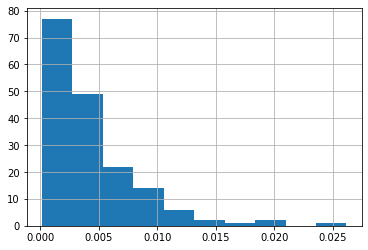

In [14]:
df_check_nans['nan_ratio'] = df_check_nans[True]/(df_check_nans[False]+df_check_nans[True])
df_check_nans['nan_ratio'].hist()

The proportion of null values for each station is very low, so we'll remove those observations.

In [15]:
df_flux = df_flux.dropna()

### 2.3 Check data distribution

<AxesSubplot:xlabel='flux', ylabel='Count'>

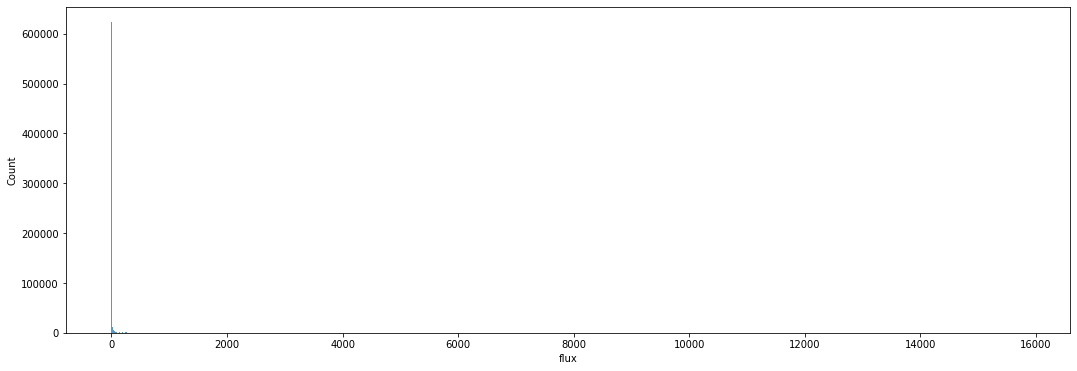

In [16]:
plt.figure(figsize=(18,6))
sns.histplot(df_flux['flux'])
#plt.hist(df_flux['flux'])

<AxesSubplot:xlabel='temp_max', ylabel='Count'>

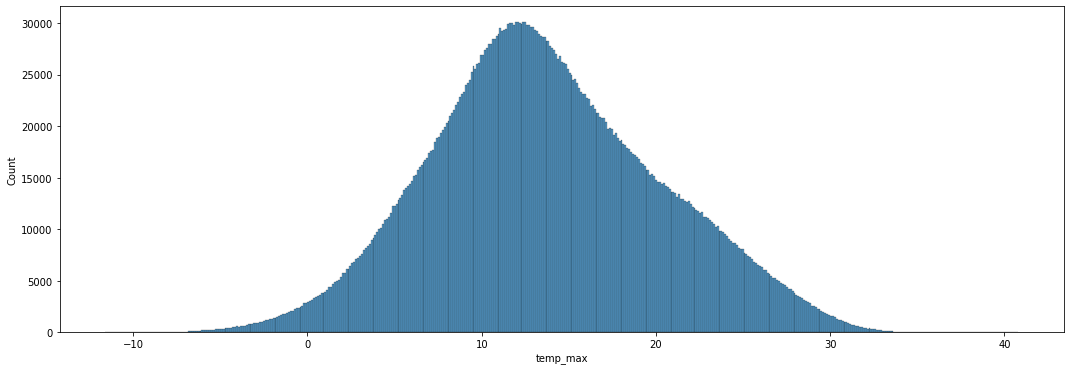

In [17]:
plt.figure(figsize=(18,6))
sns.histplot(df_flux['temp_max'])

(array([4.005386e+06, 1.252010e+05, 3.071900e+04, 9.253000e+03,
        2.955000e+03, 1.073000e+03, 3.410000e+02, 8.700000e+01,
        1.400000e+01, 8.000000e+00]),
 array([  0.      ,  21.321202,  42.642404,  63.963606,  85.284808,
        106.60601 , 127.927212, 149.248414, 170.569616, 191.890818,
        213.21202 ]),
 <BarContainer object of 10 artists>)

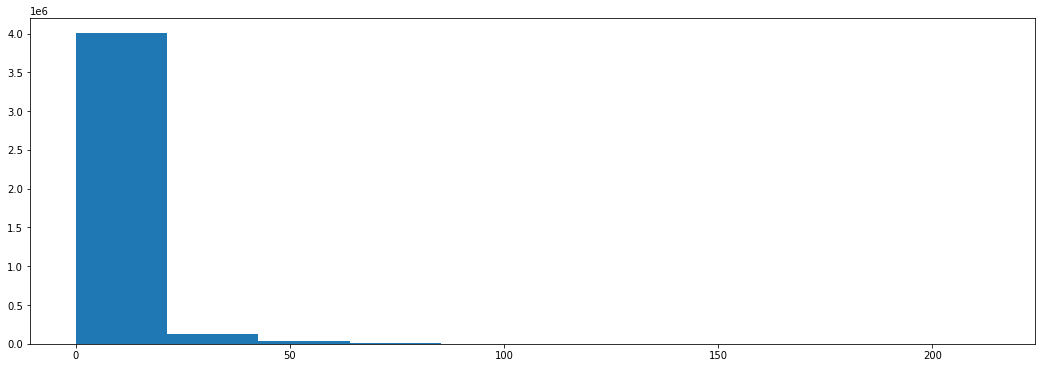

In [18]:
plt.figure(figsize=(18,6))
#sns.histplot(df_flux['precip'])
plt.hist(df_flux['precip'])

c:\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

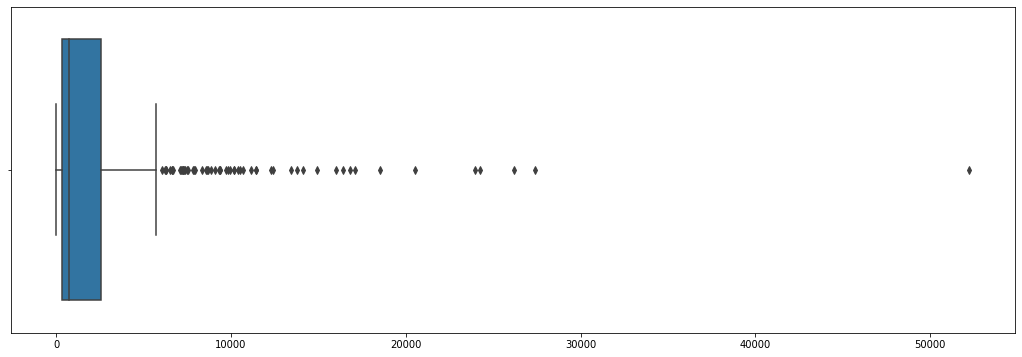

In [19]:
plt.figure(figsize=(18,6))
sns.boxplot(df_flux['area_km2'].unique())

<AxesSubplot:ylabel='Count'>

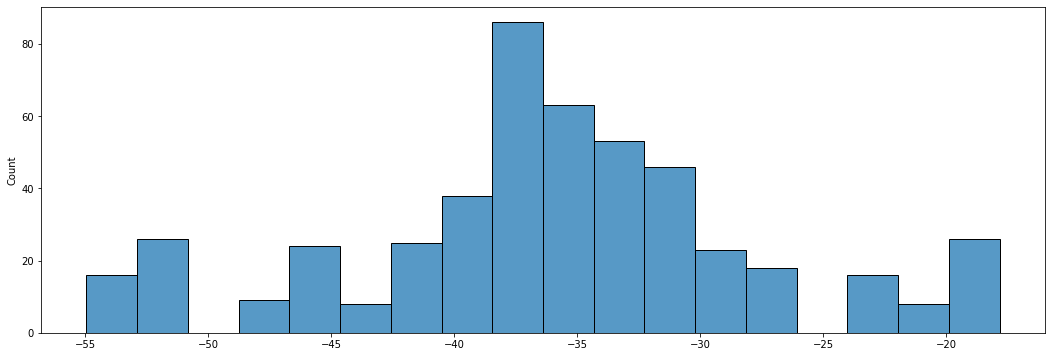

In [20]:
plt.figure(figsize=(18,6))
sns.histplot(df_flux['lat'].unique())

<AxesSubplot:ylabel='Count'>

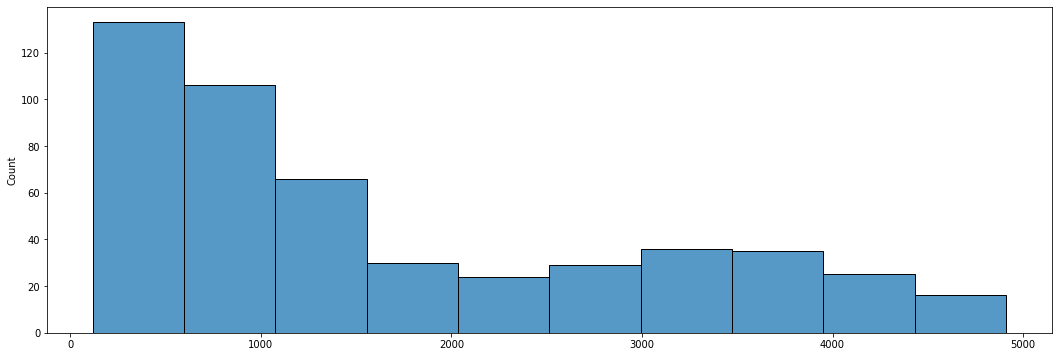

In [21]:
plt.figure(figsize=(18,6))
sns.histplot(df_flux['mean_elev'].unique())

Latitude and elevation are good candidates to be used as clustering variables. For the EDA let's look at how the flux, temperature and precipitation behave for initial clusterings on those 2. We can group stations as follows:

- Latitude:
    - ],-50]
    - ]-50,-47]
    - ]-47,-25]
    - ]-25, ]
- Mean Elevation:
    - ],2200]
    - ]2200,]

In [22]:
# create group variable for latitude, 1 is the northest group and 4 the southest
conditions = [
    (df_flux['lat']<=-50),
    (-50<df_flux['lat']) & (df_flux['lat']<=-47),
    (-47<df_flux['lat']) & (df_flux['lat']<=-25),
    (-25<df_flux['lat']),
    ]
values = ['lat_group_4', 
          'lat_group_3', 
          'lat_group_2',
          'lat_group_1']
df_flux['lat_group'] = np.select(conditions, values)
# create group variable for mean_elev, 1st group has less elevation than 2nd group
conditions = [
    (df_flux['mean_elev']<=2200),
    (2200<df_flux['mean_elev'])
    ]
values = ['mean_elev_group_1', 
          'mean_elev_group_2',]
df_flux['mean_elev_group'] = np.select(conditions, values)

[Text(0.5, 1.0, 'flux dist over chosen categorical variables')]

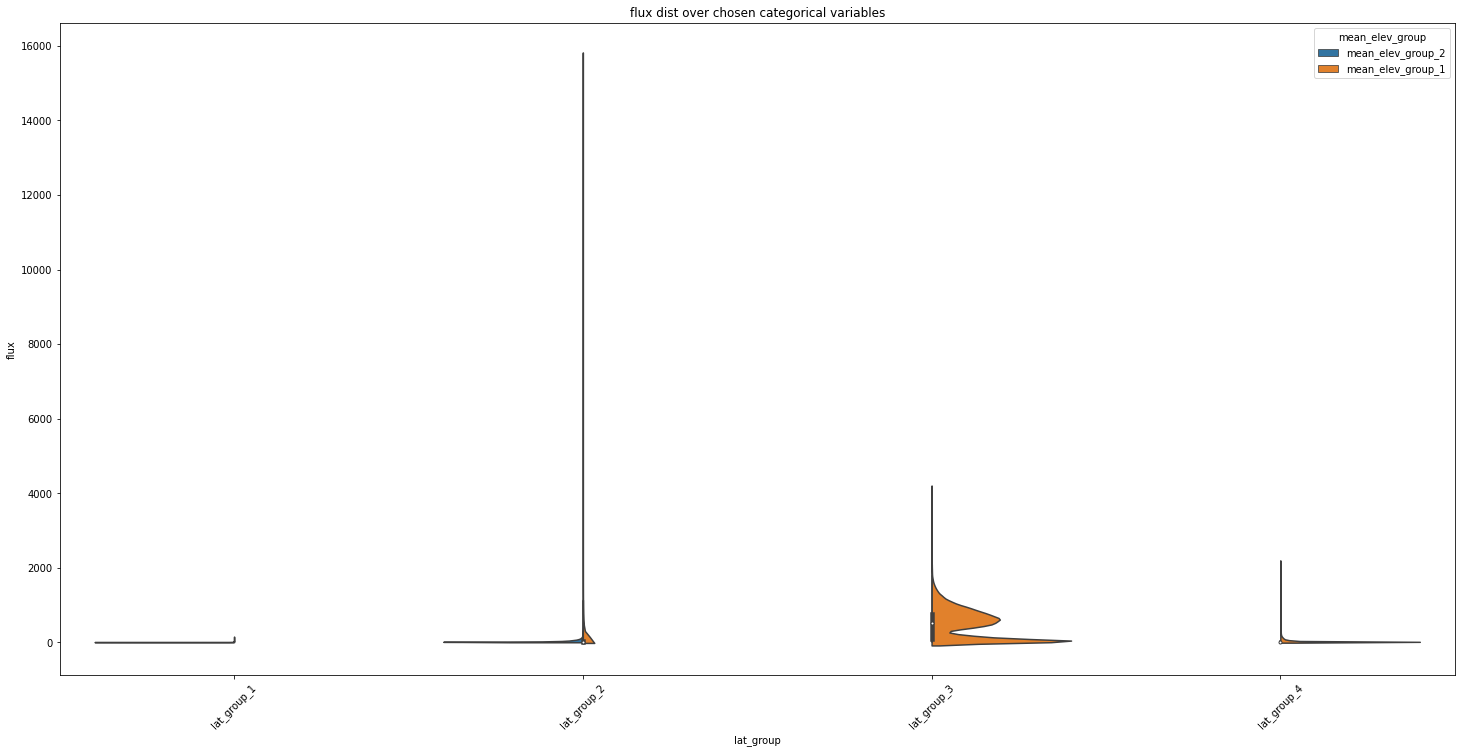

In [23]:
plt.figure(figsize=(25,12))
plt.xticks(rotation=45)
sns.violinplot(x=df_flux["lat_group"], 
            y=df_flux["flux"],
            hue=df_flux["mean_elev_group"],
            split=True,
            dodge=False).set(title='flux dist over chosen categorical variables')

[Text(0.5, 1.0, 'Precipitation dist over chosen categorical variables')]

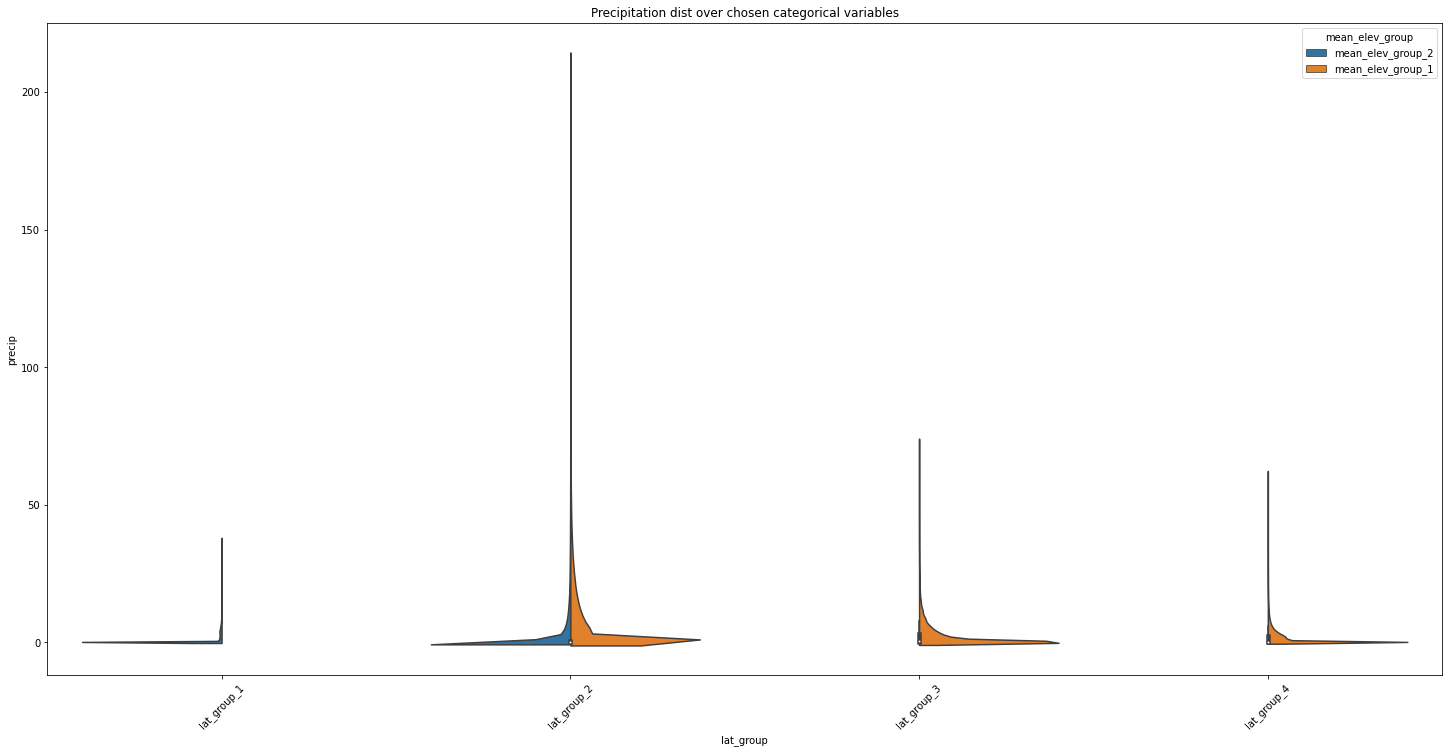

In [24]:
plt.figure(figsize=(25,12))
plt.xticks(rotation=45)
sns.violinplot(x=df_flux['lat_group'], 
            y=df_flux['precip'],
            hue=df_flux['mean_elev_group'],
            split=True,
            dodge=False).set(title='Precipitation dist over chosen categorical variables')

[Text(0.5, 1.0, 'Max Temp dist over chosen categorical variables')]

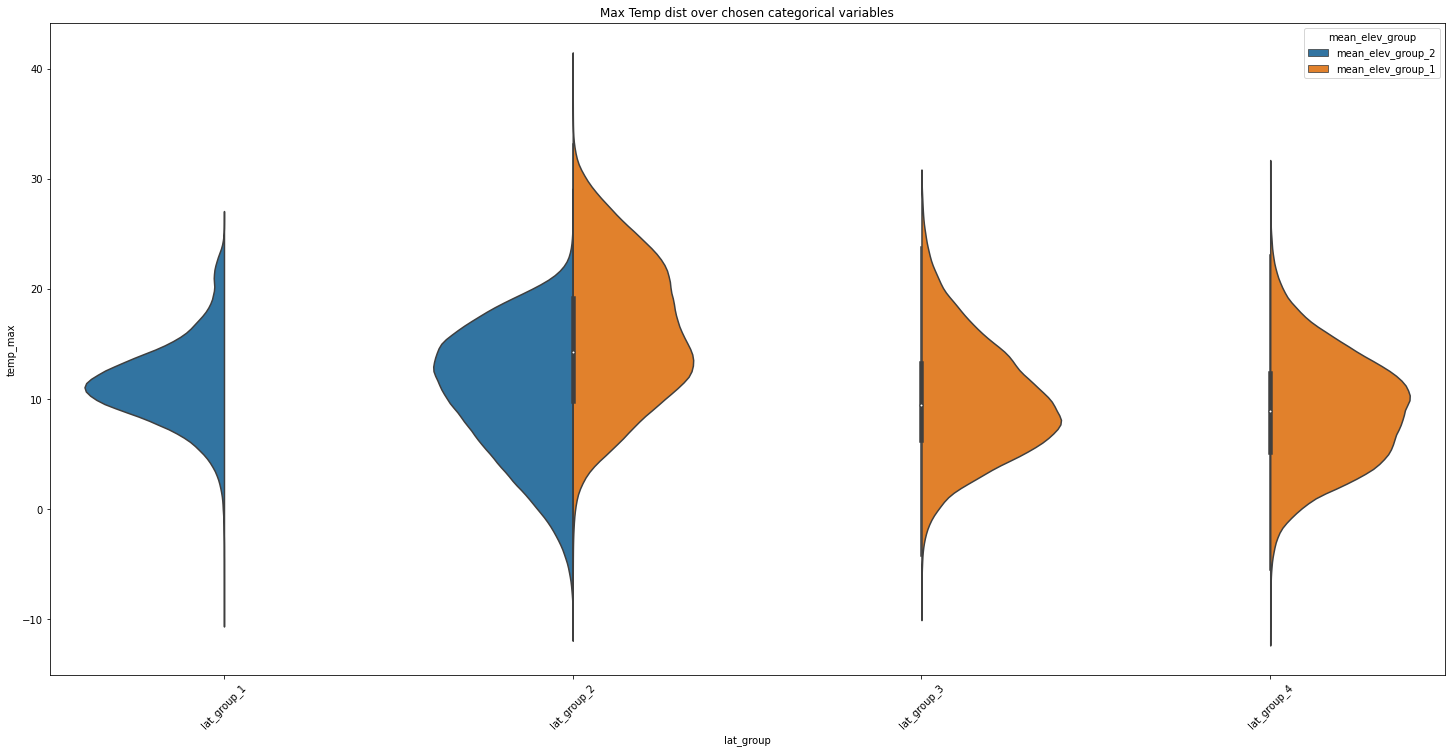

In [25]:
plt.figure(figsize=(25,12))
plt.xticks(rotation=45)
sns.violinplot(x=df_flux['lat_group'], 
            y=df_flux['temp_max'],
            hue=df_flux['mean_elev_group'],
            split=True,
            dodge=False).set(title='Max Temp dist over chosen categorical variables')

The stations that are located in the northern part of Chile all belong to the group of stations higher than 2200 meters above sea level. That would explain why the max temperature of those is not much higher than the stations in the south, which are all below 2200.

In the second group by latitude we observe that elevation has a clear effect on max temperature.

Further analysis should be made by taking a look at what happens for small values, which stations only have small values or for which periods. This will allow us to maybe clean the data and remove some faulty observations.

### Analysis of small values of flux and precipitation

We saw in its distributions that there are many zero like values for flux and precipitation, let's see if this happens many times for specific stations

In [26]:
df_flux['flux'].describe()

count    4.175037e+06
mean     5.249398e+01
std      1.674156e+02
min      0.000000e+00
25%      8.690000e-01
50%      5.180000e+00
75%      2.990000e+01
max      1.580500e+04
Name: flux, dtype: float64

In [27]:
#mask_small_values = df_flux['flux']<=1
df_flux_fsmall = df_flux[df_flux['flux']==0]
df_flux_fsmall['gauge_name'].value_counts()

Rio San Jose En Ausipar                        123
Estero Pupio En El Romero                      100
Rio Hollemberg En Desembocadura                 53
Rio Illapel En El Peral                         44
Rio Aconcagua En San Felipe                     35
Rio Blanco En Chaiten                           29
Rio Lluta En Panamericana                       26
Rio Ancoa En El Llepo                           18
Rio Hurtado En Angostura De Pangue               7
Rio Polcura En Cuatro Junta                      7
Rio Illapel En Huintil                           4
Rio Grande En Cuyano                             3
Rio Salado En Sifon Ayquina                      2
Rio Huatacondo En Copaquire                      1
Rio Hurtado En San Agustin                       1
Rio Cipreses En Dasague Laguna La Invernada      1
Name: gauge_name, dtype: int64

## 3. Plot functions

In [28]:
def plot_one_timeserie(cod_station, variable, min_date, max_date):
    """Plots a timeseries of given parameters
    
    Args:
        cod_station (int): station code of the station to plot
        variable (str): variable name to plot
        min_date (str): string of the min date to plot (format yyyy-mm-dd)
        max_date (str): string of the max date to plot (format yyyy-mm-dd)
    """
    min_date = dt.datetime.strptime(min_date, '%Y-%m-%d')
    max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
    
    mask_1 = df_flux['basin_id']==cod_station
    mask_2 = min_date <= df_flux['date']
    mask_3 = df_flux['date']<=max_date
    df_flux_filtered = df_flux[mask_1 & mask_2 & mask_3]
    
    plt.figure(figsize=(25,6))
    plt.plot(df_flux_filtered['date'], 
             df_flux_filtered[variable])
    #plt.title("Time series of "+variable+" of the station "+cod_station + "between "+str(min_date))

In [29]:
def bound_column(df,var):
    """Bound values of chosen var between 0 and 1"""
    #df = df.copy()
    return (df[var]-df[var].min())/(df[var].max()-df[var].min())    

def plot_three_timeseries(cod_station, min_date, max_date):
    """Plots 3 timeseries of given parameters
    
    Args:
        cod_station (int): station code of the station to plot
        min_date (str): string of the min date to plot (format yyyy-mm-dd)
        max_date (str): string of the max date to plot (format yyyy-mm-dd)
    """
    min_date = dt.datetime.strptime(min_date, '%Y-%m-%d')
    max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
    
    
    cols_select =['basin_id','date','flux','temp_max','precip']
    df_flux_filtered = df_flux[cols_select]
    
    df_flux_filtered['flux_n'] = bound_column(df_flux_filtered,'flux')
    df_flux_filtered['temp_max_n'] = bound_column(df_flux_filtered,'temp_max')
    df_flux_filtered['precip_n'] = bound_column(df_flux_filtered,'precip')
    
    
    mask_1 = df_flux_filtered['basin_id']==cod_station
    mask_2 = min_date <= df_flux_filtered['date']
    mask_3 = df_flux_filtered['date']<=max_date
    df_flux_filtered = df_flux_filtered[mask_1 & mask_2 & mask_3]
    
    plt.figure(figsize=(25,6))
    plt.plot(df_flux_filtered['date'], df_flux_filtered['flux_n'], label='flux')
    plt.plot(df_flux_filtered['date'], df_flux_filtered['temp_max_n'], label='temp_max')
    plt.plot(df_flux_filtered['date'], df_flux_filtered['precip_n'], label='precip')
    plt.legend()

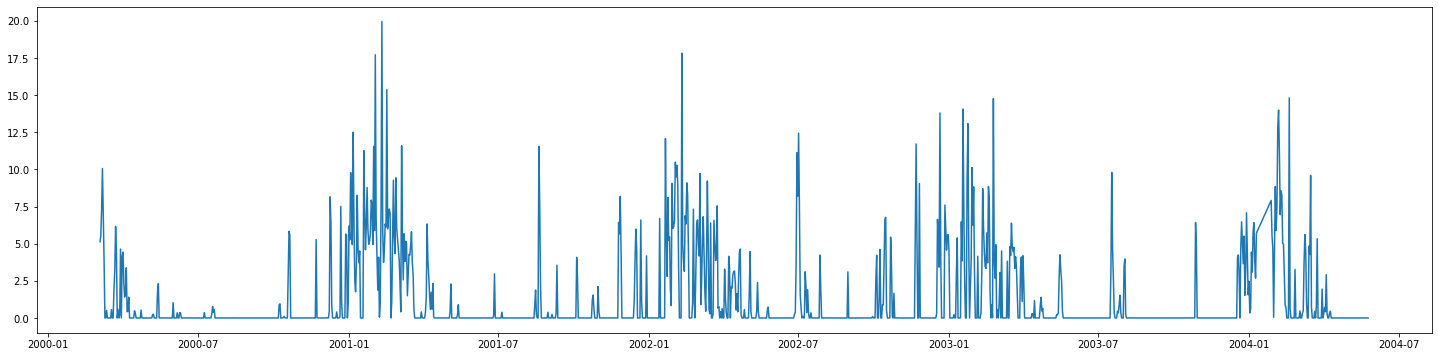

In [30]:
plot_one_timeserie(1001001,'precip','2000-03-04','2020-03-04')

C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_13508/3210905886.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flux_filtered['flux_n'] = bound_column(df_flux_filtered,'flux')
C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_13508/3210905886.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flux_filtered['temp_max_n'] = bound_column(df_flux_filtered,'temp_max')
C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_13508/3210905886.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of

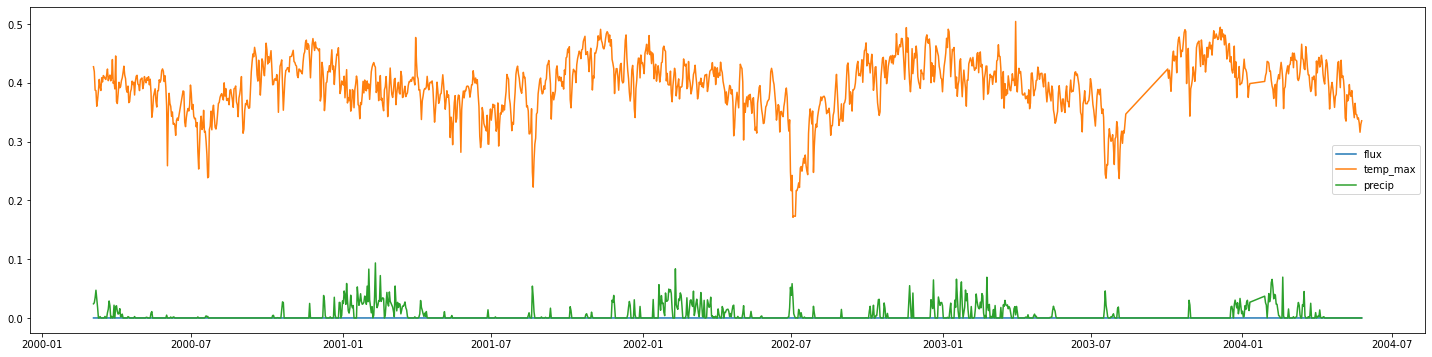

In [31]:
plot_three_timeseries(1001001,'2000-03-04','2021-08-04')

## 4. New three variables

### 4.1 Is the 95 percentile method a good way of capturing extre events?

Defining extreme events by considering those above the 95 percentile as extreme is a simple method that has some drawbacks:
- If the distribution is very concentrated in one point (high kurtosis), values that are not very different from the mode or mean can be classified as extreme and treated the same way as some very extreme values.
- If we are working with time series, like in this challenge, some values are not extreme if we look at data globally, but they will be extreme if compared to those values around it.

For those reasons I don't think this is the ideal way of capturing the extreme events. I would use other methods tipically used to find outliers, such as the interquartile range or the CUSUM method (which is more suitable for time series). For simplicity and time-constraint reasons, I will use interquartile range.

### 4.2 Classifying extreme events

Rather than considering a season, I'll compare the values of each week of the year. This way, an observation can be catalogued as extreme if its value is outside of some range given the historical distribution of the variable on that week.

In [32]:
df_flux['week_year'] = df_flux['date'].apply(lambda x: x.strftime("%V"))

In [33]:
group_cols = ['gauge_name','week_year']
agg_vars = ['flux','temp_max','precip']
df_flux_grouped_p75 = df_flux.groupby(group_cols)[agg_vars].quantile(.75).reset_index()
df_flux_grouped_p25 = df_flux.groupby(group_cols)[agg_vars].quantile(.25).reset_index()
col_name_changes_75 = {('flux'):'flux_75', 
                       ('temp_max'):'temp_max_75',
                       ('precip'):'precip_75',
                      }
col_name_changes_25 = {('flux'):'flux_25', 
                       ('temp_max'):'temp_max_25',
                       ('precip'):'precip_25',
                      }
df_flux_grouped_p75 = df_flux_grouped_p75.rename(columns=col_name_changes_75)
df_flux_grouped_p25 = df_flux_grouped_p25.rename(columns=col_name_changes_25)

In [34]:
df_flux_complete = pd.merge(df_flux,
                            df_flux_grouped_p75,
                            how='left',
                            left_on=['gauge_name','week_year'],
                            right_on=['gauge_name','week_year'],
                           )
df_flux_complete = pd.merge(df_flux_complete,
                            df_flux_grouped_p25,
                            how='left',
                            left_on=['gauge_name','week_year'],
                            right_on=['gauge_name','week_year'],
                           )
df_flux_complete['cutoff_extreme_values_flux'] = (df_flux_complete['flux_75']
                                                  + 1.5*(df_flux_complete['flux_75']
                                                         - df_flux_complete['flux_25'])
                                                  )
df_flux_complete['cutoff_extreme_values_temp'] = (df_flux_complete['temp_max_75']
                                                  + 1.5*(df_flux_complete['temp_max_75']
                                                         - df_flux_complete['temp_max_25'])
                                                  )
df_flux_complete['cutoff_extreme_values_precip'] = (df_flux_complete['precip_75']
                                                    + 1.5*(df_flux_complete['precip_75']
                                                           - df_flux_complete['precip_25']
                                                          )
                                                   )


In [35]:
df_flux_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4175037 entries, 0 to 4175036
Data columns (total 23 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   date                          datetime64[ns]
 1   basin_id                      int64         
 2   flux                          float64       
 3   precip                        float64       
 4   temp_max                      float64       
 5   gauge_name                    object        
 6   lat                           float64       
 7   lon                           float64       
 8   mean_elev                     float64       
 9   area_km2                      float64       
 10  has_nan                       bool          
 11  lat_group                     object        
 12  mean_elev_group               object        
 13  week_year                     object        
 14  flux_75                       float64       
 15  temp_max_75                   fl

In [36]:
df_flux_complete['flux_extreme'] = (df_flux_complete['flux']
                                    > df_flux_complete['cutoff_extreme_values_flux']).astype(int)
df_flux_complete['temp_extreme'] = (df_flux_complete['temp_max']
                                    > df_flux_complete['cutoff_extreme_values_temp']).astype(int)
df_flux_complete['precip_extreme'] = (df_flux_complete['precip']
                                    > df_flux_complete['cutoff_extreme_values_precip']).astype(int)
df_flux_complete

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,...,precip_75,flux_25,temp_max_25,precip_25,cutoff_extreme_values_flux,cutoff_extreme_values_temp,cutoff_extreme_values_precip,flux_extreme,temp_extreme,precip_extreme
0,1980-01-01,1001001,0.579,0.000000,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
1,1980-01-02,1001001,0.543,0.000000,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
2,1980-01-03,1001001,0.482,0.000000,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
3,1980-01-04,1001001,0.459,0.000000,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
4,1980-01-05,1001001,0.436,0.000000,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175032,2020-04-25,12930001,0.431,0.000000,4.138484,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,2.907851,0.29450,5.707051,0.0,1.553250,13.055306,7.269628,0,0,0
4175033,2020-04-26,12930001,0.362,0.000000,7.685259,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,2.907851,0.29450,5.707051,0.0,1.553250,13.055306,7.269628,0,0,0
4175034,2020-04-27,12930001,0.342,0.000000,9.646850,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,1.902880,0.32275,4.552318,0.0,1.177125,13.522310,4.757199,0,0,0
4175035,2020-04-28,12930001,0.359,0.000000,8.154713,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,1.902880,0.32275,4.552318,0.0,1.177125,13.522310,4.757199,0,0,0


## 5.  Plotting the flux_extreme

We'll take a look at the amount of extreme values each station has. 